In [954]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.
Path to dataset files: /kaggle/input/online-retail-ii-uci


In [ ]:
import pandas as pd

In [956]:
df = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")

In [ ]:
df = df.dropna(subset=['Customer ID', 'Description'])

In [ ]:
df = df.drop_duplicates()

In [ ]:
df['TotalPrice'] = df['Quantity'] * df['Price']

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.month

In [ ]:
df['IsReturn'] = (df['Quantity'] < 0).astype(int)

# Этап 2. ML (на выбор)

##  A. Кластеризация клиентов (KMeans)
*   Сгруппируйте данные по клиентам:
*      Общая выручка.
*      Количество покупок.
*      Средний чек.
*   Стандартизируйте данные (StandardScaler).
*   Обучите KMeans(n_clusters=3) и добавьте колонку Cluster.
*   Визуализируйте кластеры (scatterplot или pairplot).
*   Охарактеризуйте каждый кластер (например, “Мелкие покупатели”, “Крупные B2B”, “Редкие клиенты”).

A. Кластеризация клиентов (KMeans)

In [1035]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [1036]:
#группируем данные по клиентам: общая выручка, количество покупок, средний чек и сбрасываем индекс, чтобы превратить результат обратно в нормальный DataFrame, а не GroupBy-объект
customers = (df.groupby(['Customer ID']).agg(total_revenue=('TotalPrice','sum'), total_orders=('Invoice','count'), avg_check=('TotalPrice','mean'))).reset_index()

In [1037]:
print(customers)

      Customer ID  total_revenue  total_orders  avg_check
0         12346.0         -51.74            47  -1.100851
1         12347.0        4921.53           222  22.169054
2         12348.0        2019.40            51  39.596078
3         12349.0        4404.54           180  24.469667
4         12350.0         334.40            17  19.670588
...           ...            ...           ...        ...
5937      18283.0        2664.90           938   2.841045
5938      18284.0         436.68            29  15.057931
5939      18285.0         427.00            12  35.583333
5940      18286.0        1188.43            70  16.977571
5941      18287.0        4177.89           156  26.781346

[5942 rows x 4 columns]


In [1038]:
#стандартизируем данные (StandardScaler)
features = ['total_revenue', 'total_orders', 'avg_check'] #сначала задаем список признаков, которые будем использовать для кластеризации
scaler = StandardScaler()
x_scaler = scaler.fit_transform(customers[features]) #fit — вычисляет среднее и стандартное отклонение по каждому признаку

In [1039]:
#обучаем KMeans(n_clusters=3) и добавляем колонку Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
customers['Cluster'] = kmeans.fit_predict(x_scaler)

In [1040]:
print(customers)

      Customer ID  total_revenue  total_orders  avg_check  Cluster
0         12346.0         -51.74            47  -1.100851        0
1         12347.0        4921.53           222  22.169054        0
2         12348.0        2019.40            51  39.596078        0
3         12349.0        4404.54           180  24.469667        0
4         12350.0         334.40            17  19.670588        0
...           ...            ...           ...        ...      ...
5937      18283.0        2664.90           938   2.841045        0
5938      18284.0         436.68            29  15.057931        0
5939      18285.0         427.00            12  35.583333        0
5940      18286.0        1188.43            70  16.977571        0
5941      18287.0        4177.89           156  26.781346        0

[5942 rows x 5 columns]


<Figure size 1000x500 with 0 Axes>

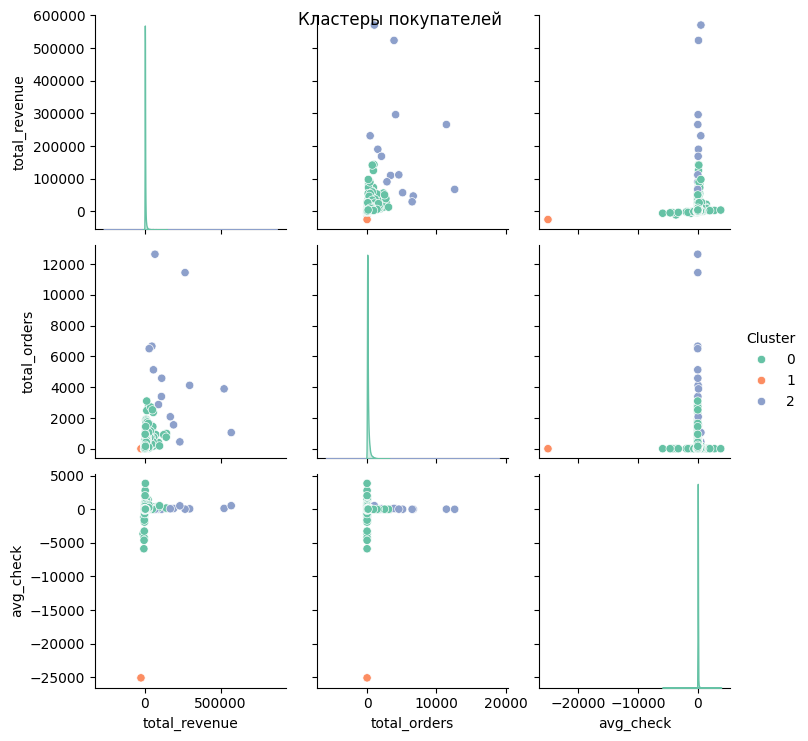

In [ ]:
#визуализируем кластеры (scatterplot или pairplot)
plt.figure(figsize=(10,5))
sns.pairplot(customers, vars=features, hue='Cluster', palette="Set2") #таблица клиентов, список признаков для столбцов, hue — цвет точки зависит от кластера, palette='Set2' — цветовая схема
plt.suptitle('Кластеры покупателей')
plt.show()

In [1008]:
#охарактеризуем каждый кластер (например, “Мелкие покупатели”, “Крупные B2B”, “Редкие клиенты”)
cluster_profile = customers.groupby(['Cluster'])[features].mean() #сначала группируем клиентов по номеру кластера
print(cluster_profile)

         total_revenue  total_orders     avg_check
Cluster                                           
0          2287.345154    123.425679     21.782462
1        -25111.090000      1.000000 -25111.090000
2        197000.546429   4738.571429    115.286659


*  Кластер 0 (5927 человек): низкая выручка, мало покупок, средний чек невысокий = “Мелкие покупатели”.
*  Кластер 1 (14 человек): высокая выручка, много покупок, хороший средний чек = “Крупные, B2B-клиенты”.
*  Кластер 2 (1 человек): покупок мало, средний чек очень высокий = “Редкие клиенты”.

В. Регрессия (LinearRegression)

##  Регрессия (LinearRegression)
*   Цель: предсказать TotalRevenue клиента.
*   Фичи: средний чек, количество покупок, количество возвратов, среднее количество товаров в заказе.
*   Разделите данные на train/test (80/20).
*   Обучите LinearRegression.
*   Посчитайте MAE, RMSE, R².
*   Постройте график "фактические vs предсказанные значения".

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1010]:
#группируем данные по клиентам: выручка, количество покупок, средний чек, количество возвратов, среднее количество товаров в заказе и сбрасываем индекс, чтобы превратить результат обратно в нормальный DataFrame, а не GroupBy-объект
df_customers = (df.groupby(['Customer ID']).agg(total_revenue=('TotalPrice','sum'), total_orders=('Invoice','count'), avg_check=('TotalPrice','mean'), returns_count=('IsReturn','sum'), avg_quantity=('Quantity','mean'))).reset_index()

In [1011]:
print(df_customers)

      Customer ID  total_revenue  total_orders  avg_check  returns_count  \
0         12346.0         -51.74            47  -1.100851             13   
1         12347.0        4921.53           222  22.169054              0   
2         12348.0        2019.40            51  39.596078              0   
3         12349.0        4404.54           180  24.469667              5   
4         12350.0         334.40            17  19.670588              0   
...           ...            ...           ...        ...            ...   
5937      18283.0        2664.90           938   2.841045              0   
5938      18284.0         436.68            29  15.057931              1   
5939      18285.0         427.00            12  35.583333              0   
5940      18286.0        1188.43            70  16.977571              3   
5941      18287.0        4177.89           156  26.781346              1   

      avg_quantity  
0         1.127660  
1        13.364865  
2        53.215686  
3  

In [1012]:
#создаем список фичей: средний чек, количество покупок, количество возвратов, среднее количество товаров в заказе
features = ['avg_check', 'total_orders', 'returns_count', 'avg_quantity']

In [1013]:
#задаем Х и у
X = df_customers[features]
y = df_customers['total_revenue'] #целевая переменная

In [1014]:
#разделяем данные на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #test_size=0.2 - 80% обучение и 20% тест

In [1015]:
#обучаем LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [1016]:
#предсказание (что модель считает правильным ответом, основываясь на данных, которые она никогда раньше не видела)
y_pred = model.predict(X_test)

In [1017]:
#считаем метрики: MAE (средняя абсолютная ошибка), RMSE (корень среднеквадратичной ошибки), R²(качество модели (0–1)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

In [1018]:
print('MAE:', MAE)
print('RMSE:', RMSE)
print('R²:', R2)

MAE: 1998.7508035888
RMSE: 17208.761341875845
R²: 0.09657811922100268


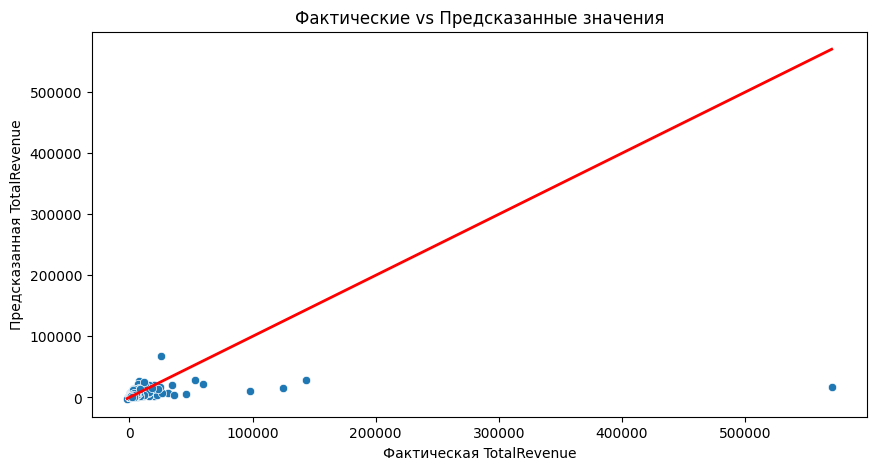

In [1019]:
#строим график "фактические vs предсказанные значения"
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Фактическая TotalRevenue')
plt.ylabel('Предсказанная TotalRevenue')
plt.title('Фактические vs Предсказанные значения')

plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], color="red", linewidth=2) #линия идеального предсказания (тренда)
plt.show()

##  Этап 3. Дополнительные задания (по желанию)
*   Найдите клиентов, которые чаще всего делают возвраты.
*   Постройте Pareto-анализ (80/20): какая доля клиентов приносит 80% выручки?
*   Постройте временной ряд выручки по месяцам и определите тренд.
*   Сравните средний чек между странами — с помощью sns.boxplot.
*   Выделите клиентов, которые делали заказы более чем в 3 разных месяцах.

In [1020]:
#1 Найдите клиентов, которые чаще всего делают возвраты (IsReturn).
top_return_clients = df.groupby(['Customer ID']).agg({'IsReturn':'sum'}).sort_values('IsReturn', ascending=False).head(5)

In [1021]:
print(top_return_clients)

             IsReturn
Customer ID          
14911.0           365
15311.0           273
17511.0           209
17841.0           203
13798.0           191


In [1022]:
#2 Постройте Pareto-анализ (80/20): какая доля клиентов приносит 80% выручки (TotalPrice)?
df_positive_TotalPrice = df[df['TotalPrice'] > 0].copy() #сначала создадим отдельный датафрейм с только положительными значениями выручки по клиентам
revenue_client = df_positive_TotalPrice.groupby(['Customer ID']).agg({'TotalPrice':'sum'}) #сгруппируем выручку по клиентам

In [1023]:
print(revenue_client)

             TotalPrice
Customer ID            
12346.0        77556.46
12347.0         4921.53
12348.0         2019.40
12349.0         4428.69
12350.0          334.40
...                 ...
18283.0         2664.90
18284.0          461.68
18285.0          427.00
18286.0         1296.43
18287.0         4182.99

[5878 rows x 1 columns]


In [1024]:
print('Клиентов с выручкой <= 0:', (revenue_client <= 0).sum())

Клиентов с выручкой <= 0: TotalPrice    0
dtype: int64


In [1025]:
#считаем кумулятивную долю
cum_revenue = revenue_client.cumsum() / revenue_client.sum()

In [1026]:
print(cum_revenue)

             TotalPrice
Customer ID            
12346.0        0.004464
12347.0        0.004747
12348.0        0.004863
12349.0        0.005118
12350.0        0.005137
...                 ...
18283.0        0.999633
18284.0        0.999660
18285.0        0.999685
18286.0        0.999759
18287.0        1.000000

[5878 rows x 1 columns]


In [1027]:
#оставляем клиентов, которые дают 80% выручки
pareto_clients = cum_revenue[cum_revenue <= 0.8]

In [1028]:
#вычисляем долю таких клиентов среди всех
pareto_ratio = len(pareto_clients) / len(revenue_client)
print('Доля клиентов, дающих 80% выручки:', pareto_ratio)

Доля клиентов, дающих 80% выручки: 1.0


Pareto-эффекта нет: клиентская база очень равномерная (каждый даёт немного), нет такого, что “20% клиентов дают 80% выручки” (скорее 90% клиентов дают 95% выручки), данные не соответствуют классической модели Парето.

In [1029]:
#3 Постройте временной ряд выручки (TotalPrice) по месяцам (InvoiceMonth) и определите тренд.
m_revenue = df.groupby(['InvoiceMonth']).agg({'TotalPrice':'sum'}).reset_index() #группируем выручку по месяцам и сбрасываем индекс, чтобы превратить результат обратно в нормальный DataFrame, а не GroupBy-объект

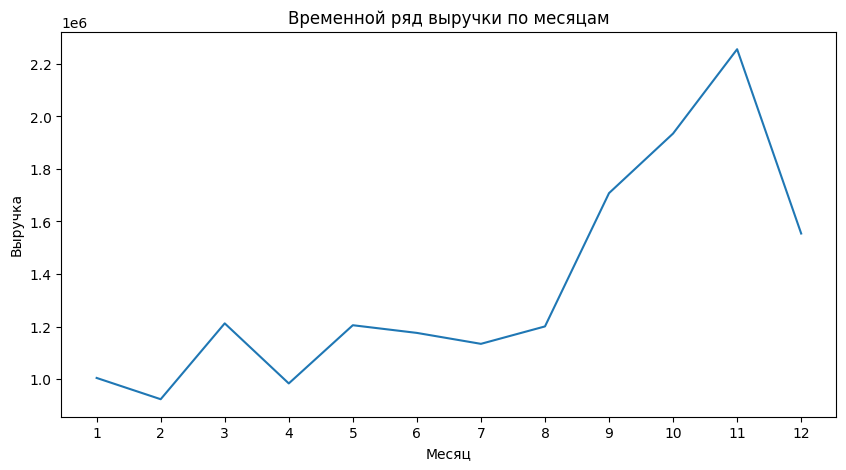

In [1030]:
#строим линейный график
plt.figure(figsize=(10,5))
sns.lineplot(m_revenue, x='InvoiceMonth', y='TotalPrice')
plt.title('Временной ряд выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(range(1, 13)) #задает значения х от 1 до 12
plt.show()

Временной ряд выручки показывает восходящий тренд, который особенно выражен во второй половине года. Наблюдается сезонный рост в период с августа по ноябрь, достигающий максимума в ноябре. Начало года характеризуется стабильными значениями и отсутствием явного тренда. В декабре виден ожидаемый спад после сезонного пика.

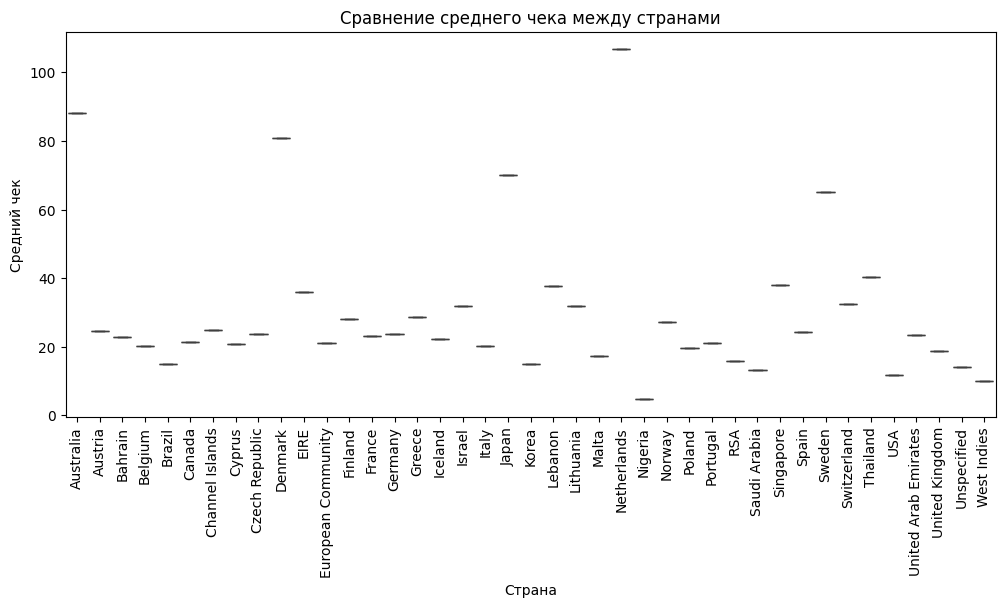

In [1031]:
#4 Сравните средний чек (avg_check) между странами — с помощью sns.boxplot.
avg_check = (df.groupby(['Country']).agg(total_orders=('Invoice','count'), total_revenue=('TotalPrice','sum'))) #группируем все заказы и выручку по странам
avg_check['avg_check'] = avg_check['total_revenue'] / avg_check['total_orders'] #считаем средний чек

plt.figure(figsize=(12,5))
sns.boxplot(x=avg_check.index, y=avg_check['avg_check']) #индекс (список стран), средний чек
plt.xticks(rotation=90) #поворот подписей стран, чтобы не налезали
plt.title('Сравнение среднего чека между странами')
plt.xlabel('Страна')
plt.ylabel('Средний чек')
plt.show()

In [1032]:
#5 Выделите клиентов, которые делали заказы более чем в 3 разных месяцах (InvoiceMonth).
active_clients = df.groupby(['Customer ID'])['InvoiceMonth'].nunique().loc[lambda x: x > 3] #клиент, месяц заказа, количество уникальных месяцев, оставляет тех, у кого месяц ≥ 4

In [1033]:
active_clients = active_clients.sort_values(ascending=False)

In [1034]:
print(active_clients)

Customer ID
18229.0    12
15023.0    12
18283.0    12
16839.0    12
16814.0    12
           ..
12352.0     4
18277.0     4
18232.0     4
18218.0     4
18210.0     4
Name: InvoiceMonth, Length: 2340, dtype: int64
